In [753]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from astropy.stats import sigma_clip
from scipy.stats import entropy

rng = np.random.default_rng()

In [754]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0', 'log_x1']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni', 'log_mej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [755]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [756]:
data = np.load("fitted_sne_real_012326.npz", allow_pickle=True)
phot_data = np.load("fitted_sne_real_012126_phot.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
true_ia_phot_sne = phot_data['ia']
true_ibc_phot_sne = phot_data['ibc']
all_phot_sne = np.concatenate((true_ia_phot_sne, true_ibc_phot_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(252, 2674, 0.9057591623036649)

In [757]:
sum(np.array([sn.ia_fit['x1'] for sn in all_sne]) <= 0), min(np.array([sn.ia_fit['x1'] for sn in all_sne]))

(1083, -4.9999999991920685)

In [758]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

for sn in all_phot_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

In [759]:
all_sne[100].true_class

'SN Ia'

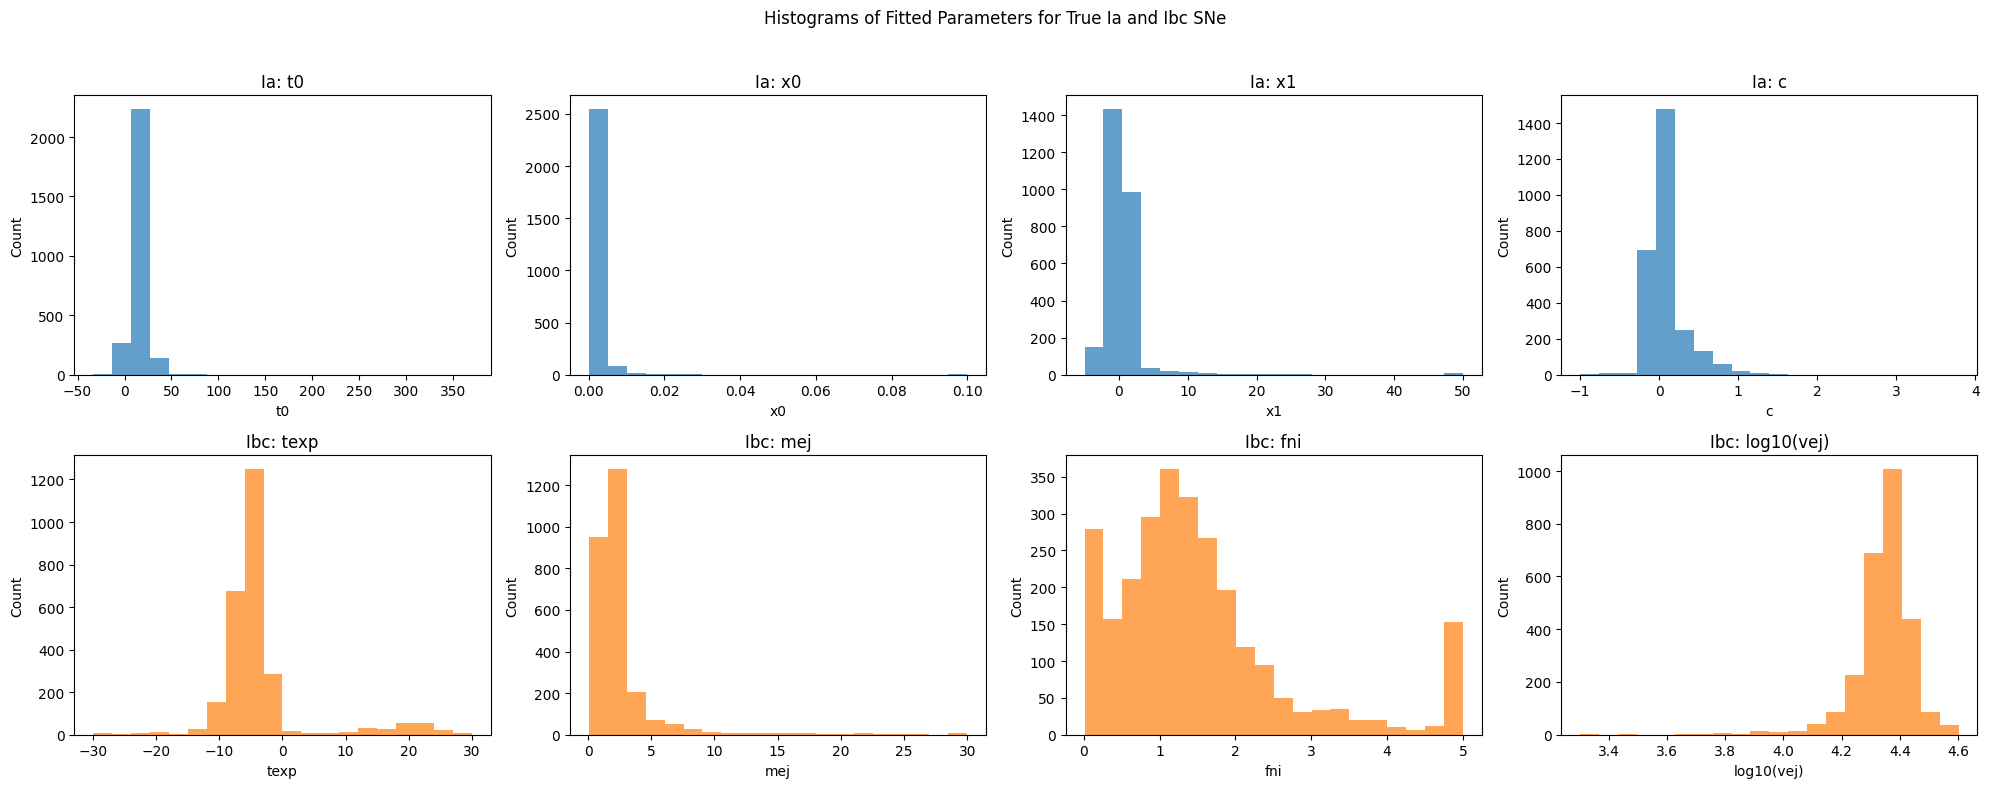

In [760]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

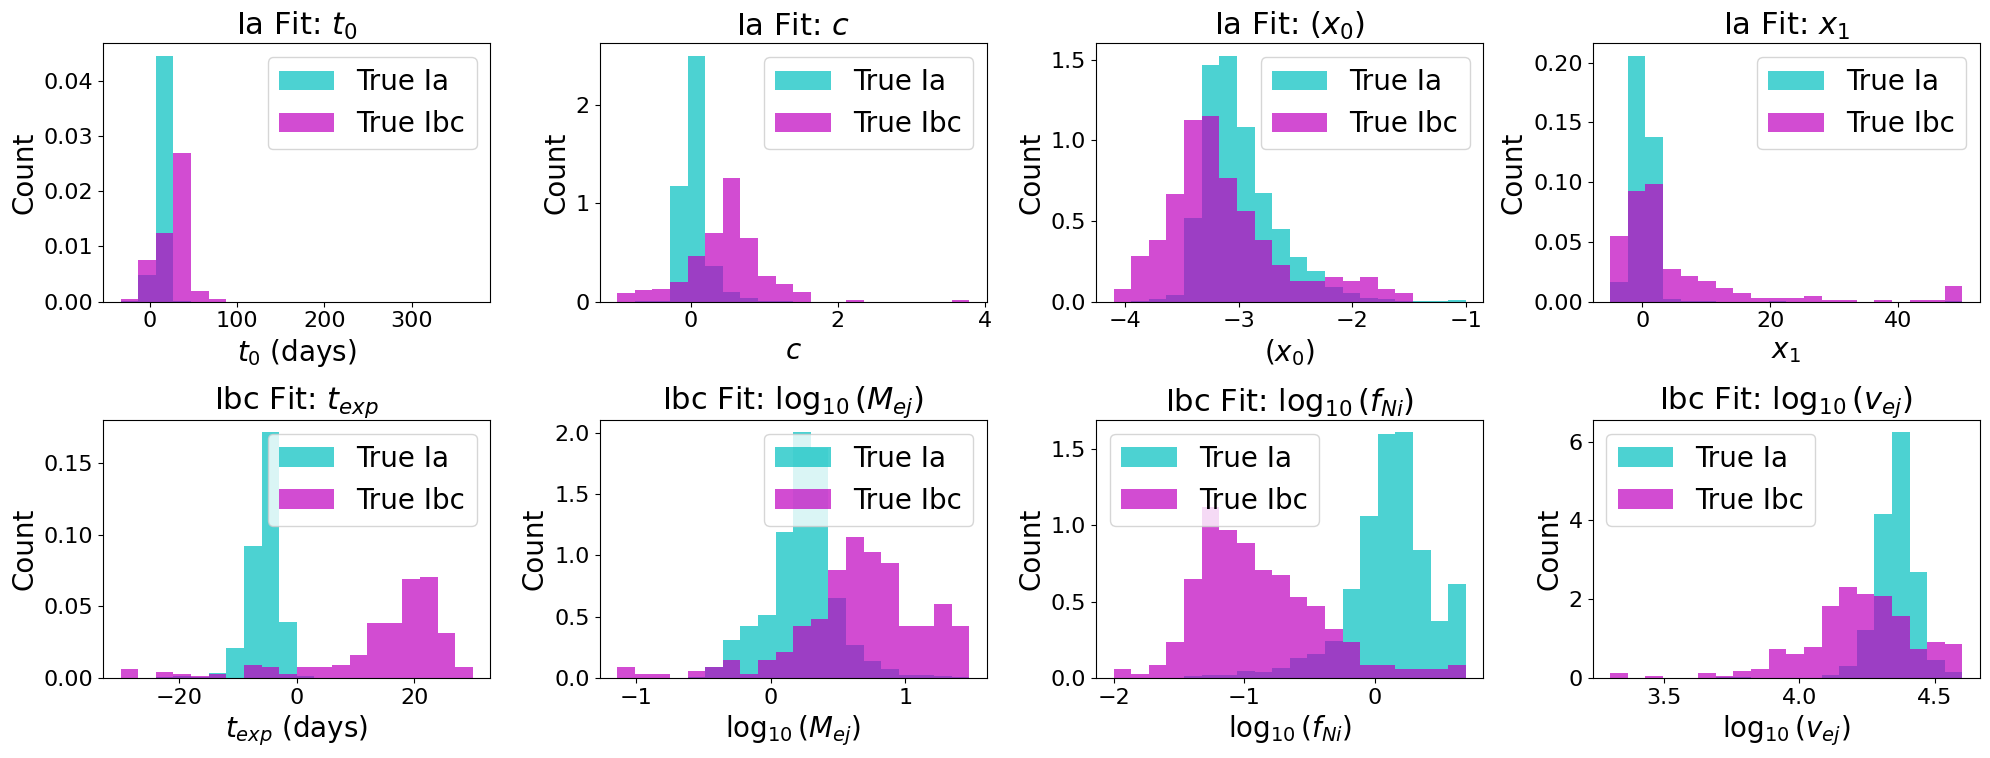

In [761]:
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',

    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',

    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$(x_0)$',
}

param_labels_no_units = {
    't0': r'$t_0$',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$',
    'mej': r'$M_{ej}$',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$(x_0)$',
}


labelfontsize = 20
titlefontsize = 22
tickfontsize = 16

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
# fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names[:4]):
for i, param in enumerate(['t0', 'c', 'x0', 'x1']):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=True)
    axes[0, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=True)
    axes[0, i].set_title(f"Ia Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[0, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[0, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[0, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[0, i].legend(fontsize=labelfontsize)

# Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
for i, param in enumerate(['texp', 'log_mej',  'log_fni', 'log_vej']):

    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=True)
    axes[1, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=True)
    axes[1, i].set_title(f"Ibc Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[1, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[1, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[1, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[1, i].legend(fontsize=labelfontsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [762]:
# fig.savefig("figures/fitted_params_histogram.pdf", bbox_inches='tight')

Here we have 8 parameters that we can use to constrain the mixing fraction

In [763]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [764]:
def get_param_samples(param_name, sn_sample = all_sne):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in sn_sample])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in sn_sample])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([2.632e+03, 2.700e+01, 8.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([7.88257576e-05, 1.00709432e-02, 2.00630606e-02, 3.00551780e-02,
        4.00472955e-02, 5.00394129e-02, 6.00315303e-02, 7.00236477e-02,
        8.00157652e-02, 9.00078826e-02, 1.00000000e-01]),
 <BarContainer object of 10 artists>)

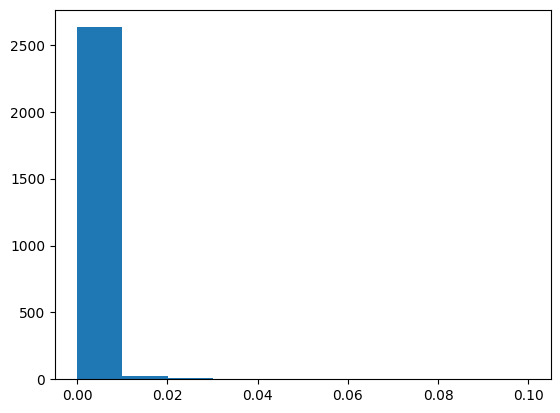

In [765]:
plt.hist(get_param_samples('x0'))

In [766]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(2674, 1)

In [933]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'log_x1', 'log_x0', 'log_fni', 'log_vej', 'x1', 'x0', 'fni']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_, sigmas_a[param_name], sigmas_b[param_name])
    # mus_a[param_name] = np.median(get_param_samples(param_name)) - 3*np.std(get_param_samples(param_name))
    # mus_b[param_name] = np.median(get_param_samples(param_name)) + 3*np.std(get_param_samples(param_name))
    # sigmas_a[param_name] = np.std(get_param_samples(param_name))
    # sigmas_b[param_name] = np.std(get_param_samples(param_name))

t0 [0.87787317 0.12212683] 2.995297751176268 29.326360327077335
c [0.7731107 0.2268893] 0.08498103851468289 0.40329784372592203
mej [0.88152856 0.11847144] 0.8003559923680817 6.521519089289408
texp [0.91583592 0.08416408] 3.066960271302946 5.321490381762076
log_x1 [0.93505778 0.06494222] 0.1051080254139506 1.6480785495365453
log_x0 [0.70791764 0.29208236] 0.19916022676005493 0.4654446927432
log_fni [0.8608402 0.1391598] 0.25866029916427435 0.38545060707297646
log_vej [0.89797445 0.10202555] 0.06393312343088557 0.24600258580061424
x1 [0.9549454 0.0450546] 1.2217471334941759 15.378164205691183
x0 [0.95904906 0.04095094] 0.001384611940479342 0.018046039032134958
fni [0.88368974 0.11631026] 0.6761847399256565 0.8780703437574174


In [934]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': []}

# params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
# params_to_use = ['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
params_to_use = ['c', 'mej', 'log_x0', 'log_fni']

# params_to_use = list(mus_a.keys())  # Use all parameters for fitting

sigma_clip_masks = {}
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    clipped = sigma_clip(param_samples, sigma=10, maxiters=3)
    sigma_clip_masks[param_name] = ~clipped.mask
    sigma_clip_masks[param_name] = np.ones_like(sigma_clip_masks[param_name])
    print(f"{param_name}: {sum(clipped.mask)} samples clipped")


len(all_sne), len(true_ia_sne)/len(all_sne)

weights = np.ones(len(all_sne))
for i, sn in enumerate(true_ia_sne):
    weights[i] = len(true_ia_sne) / (len(all_sne) - len(true_ia_sne))
    weights[i] = 1.0

# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)
        mask = sigma_clip_masks[param_name]
        param_samples = param_samples[mask]
        these_weights = weights[mask]

        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        # mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        # mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        # sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        # sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))


        mus_a[param_name] = np.sum(these_weights * gammas_a[param_name] * param_samples) / np.sum(these_weights * gammas_a[param_name])
        mus_b[param_name] = np.sum(these_weights * gammas_b[param_name] * param_samples) / np.sum(these_weights * gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(these_weights * gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(these_weights * gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(these_weights * gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(these_weights * gammas_b[param_name]))

        if sigmas_a[param_name] < 0.001:
            sigmas_a[param_name] = 0.001
        if sigmas_b[param_name] < 0.001:
            sigmas_b[param_name] = 0.001
    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], 
                                     get_param_samples(param_name)[sigma_clip_masks[param_name]], alpha)

print(lls[-1])
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
    gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    gamma_total = (gammas_a[param_name] + gammas_b[param_name])
    gammas_a[param_name] /= gamma_total
    gammas_b[param_name] /= gamma_total
    

c: 1 samples clipped
mej: 0 samples clipped
log_x0: 0 samples clipped
log_fni: 0 samples clipped
Alpha 0.3876340020738613
Alpha 0.4989630694070023
Alpha 0.5718921222141253
Alpha 0.6244968840089457
Alpha 0.6631381257734096
Alpha 0.6922795336577177
Alpha 0.7149248311973061
Alpha 0.7329336244054268
Alpha 0.7474555025672869
Alpha 0.7592553672836787
Alpha 0.7688911322681753
Alpha 0.7767945161709519
Alpha 0.7833076418233051
Alpha 0.7887031586590794
Alpha 0.7931982348399724
Alpha 0.7969655948652549
Alpha 0.8001425181522267
Alpha 0.8028381510986835
Alpha 0.8051393871248592
Alpha 0.8071155542278985
Alpha 0.8088221300278868
Alpha 0.8103036745553307
Alpha 0.8115961388978812
Alpha 0.8127286784173382
Alpha 0.8137250742658871
Alpha 0.8146048463391511
Alpha 0.8153841240116451
Alpha 0.816076327362062
Alpha 0.8166927005566734
Alpha 0.8172427301656772
Alpha 0.8177344740660829
Alpha 0.8181748209217881
Alpha 0.8185696957598991
Alpha 0.818924223655022
Alpha 0.8192428607987258
Alpha 0.8195295001103138
Alpha

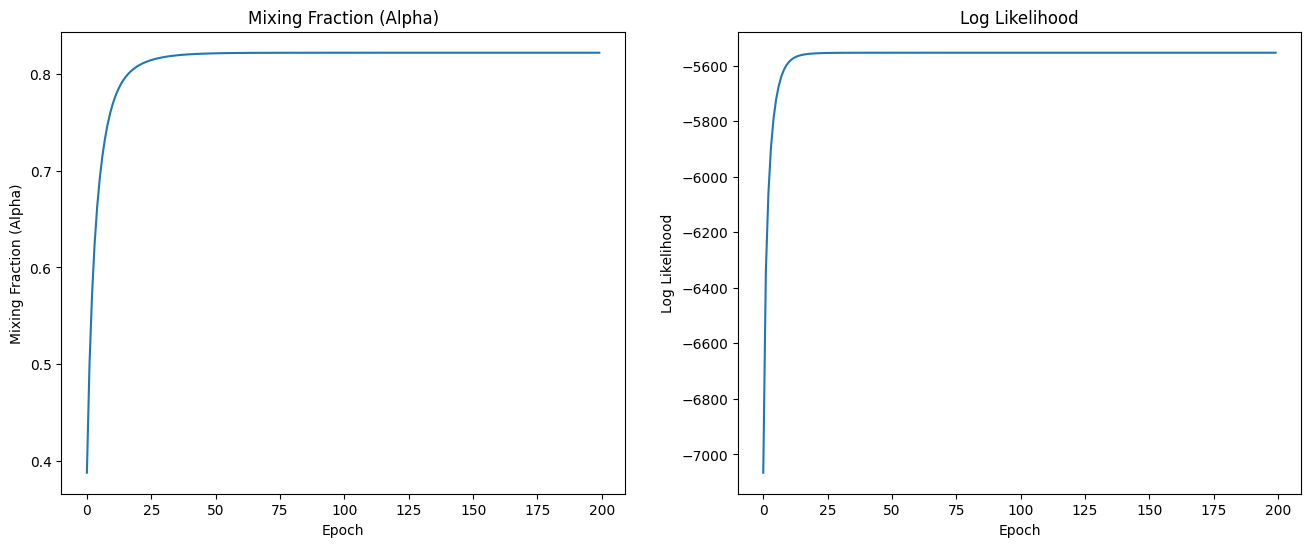

In [935]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [936]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  18.,   17.,  176.,   53.,   65.,   58.,   63.,  257.,  230.,
        1737.]),
 array([2.78787412e-05, 9.74864496e-02, 1.94945020e-01, 2.92403591e-01,
        3.89862162e-01, 4.87320733e-01, 5.84779304e-01, 6.82237875e-01,
        7.79696446e-01, 8.77155017e-01, 9.74613588e-01]),
 <BarContainer object of 10 artists>)

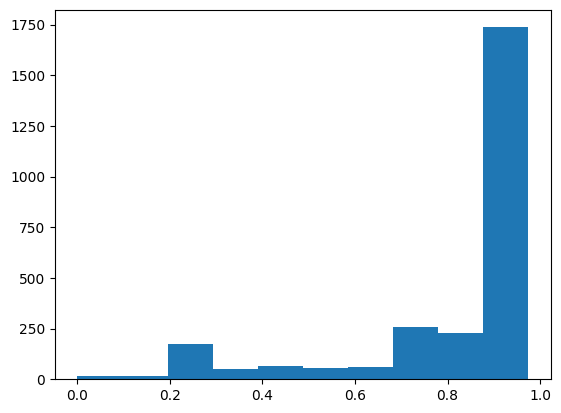

In [937]:
plt.hist(prob_a)

In [938]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in all_sne]

# true_classes

2282 200 140 52
0.9281974569932685


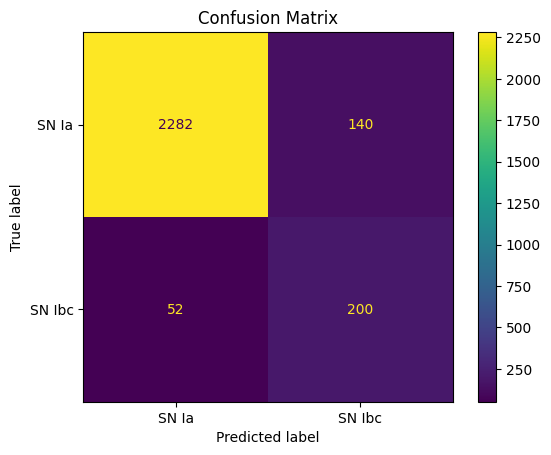

Ia accuracy: 0.9421965317919075
Ibc accuracy: 0.7936507936507936


In [942]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("Ia accuracy:", (num_correct_ia) / (num_correct_ia + num_wrong_true_ia))
print("Ibc accuracy:", (num_correct_ibc) / (num_correct_ibc + num_wrong_true_ibc))

In [943]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a >=4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


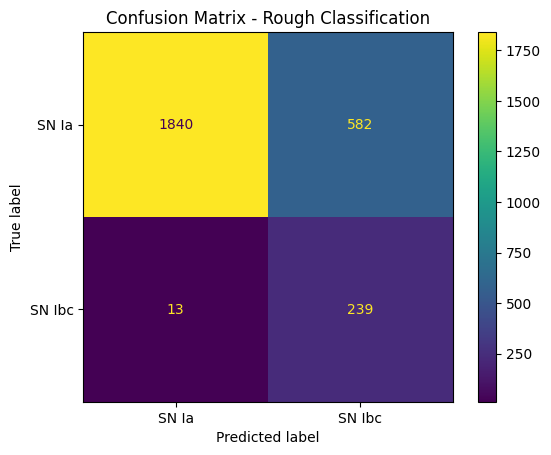

1840 239 582 13
0.7774869109947644


In [944]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

cm = confusion_matrix(true_classes, classifications_rough, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix - Rough Classification")
plt.show()

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

In [945]:
params_to_use

['c', 'mej', 'log_x0', 'log_fni']

{'c': 1.5299643552220983, 'mej': 0.9855159759830552, 'log_x0': 1.0414665597203439, 'log_fni': 38.08470627900881}
2263 219 159 33
0.9281974569932685


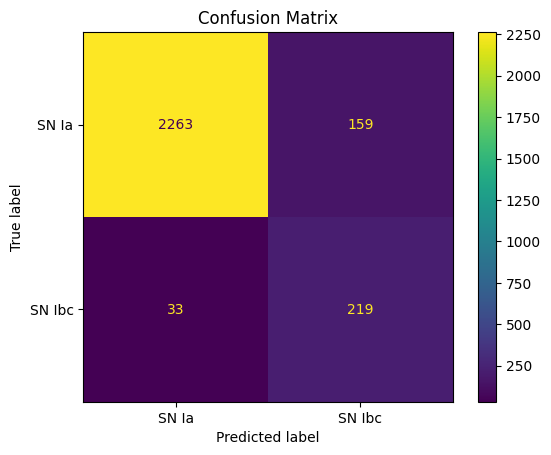

In [946]:
from scipy.stats import entropy

param_weights = {}
for param in params_to_use:
    ia_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
               for sn in true_ia_sne]
    ibc_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
                for sn in true_ibc_sne]
    
    # Use histogram-based KL divergence as weight
    bins = np.histogram_bin_edges(ia_vals + ibc_vals, bins=30)
    p_ia, _ = np.histogram(ia_vals, bins=bins, density=True)
    p_ibc, _ = np.histogram(ibc_vals, bins=bins, density=True)
    p_ia = p_ia + 1e-100  # avoid zeros
    p_ibc = p_ibc + 1e-100
    param_weights[param] = entropy(p_ia, p_ibc)

# Then in classification:
weighted_probs = np.zeros(len(all_sne))
for i in range(len(all_sne)):
    weighted_probs[i] = sum(param_weights[p] * gammas_a[p][i] for p in params_to_use) / \
                sum(param_weights[p] * (gammas_a[p][i] + gammas_b[p][i]) for p in params_to_use)

print(param_weights)

# Classify SNe based on weighted probabilities
weighted_classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in weighted_probs]
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, weighted_classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, weighted_classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [947]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [948]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

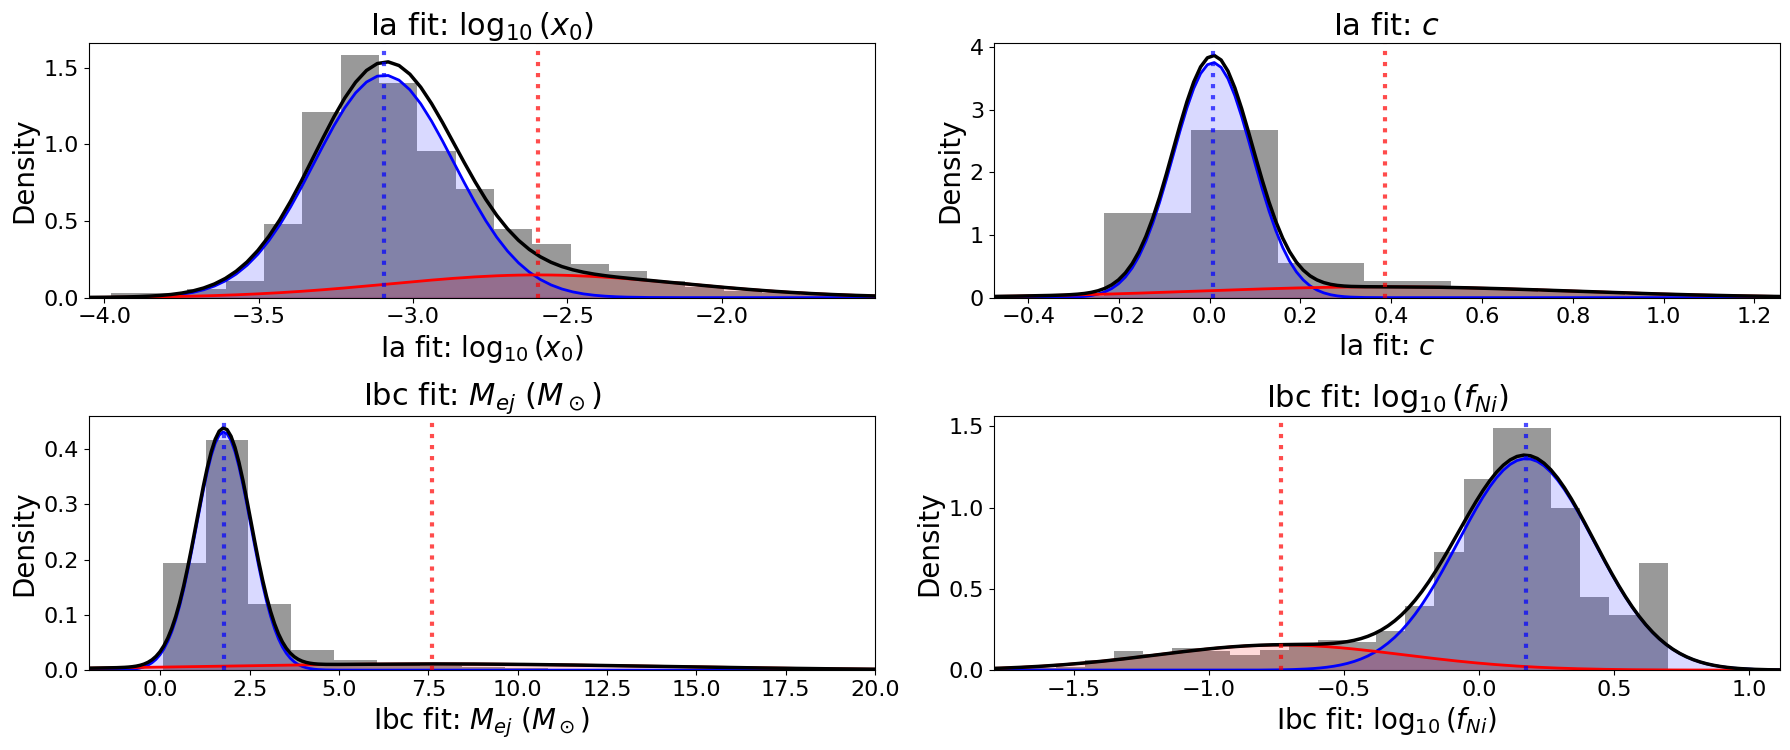


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
log_x0          -3.0937     0.2261    -2.5954     0.4791
c                0.0071     0.0874     0.3869     0.4102
mej              1.7743     0.7613     7.6140     6.3415
log_fni          0.1748     0.2522    -0.7346     0.4584


In [949]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-50, 100, 200),
    'log_x0': np.linspace(-6, 1, 200),
    'x1': np.linspace(-5, 50, 200),
    'c': np.linspace(-1, 2, 200),
    'texp': np.linspace(-20, 50, 200),
    'mej': np.linspace(-2, 20, 200),
    'log_fni': np.linspace(-3, 2, 200),
    'fni': np.linspace(0, 3, 200),
    'log_vej': np.linspace(3.5, 5, 200),
    'log_x1': np.linspace(-2, 2, 200),
    'log_mej': np.linspace(-1, 2, 200)
}

# Parameter display names
param_labels = {
    't0': r'Ia fit: $t_0$ (days)',
    'log_x0': r'Ia fit: $\log_{10}(x_0)$',
    'log_x1': r'Ia fit: $\log_{10}(x_1 + 5)$',
    'x1': r'Ia fit: $x_1$',
    'c': r'Ia fit: $c$',
    'texp': r'Ibc fit: $t_{exp}$ (days)',
    'mej': r'Ibc fit: $M_{ej}$ ($M_\odot$)',
    'log_fni': r'Ibc fit: $\log_{10}(f_{Ni})$',
    'fni': r'Ibc fit: $f_{Ni}$',
    'log_vej': r'Ibc fit: $\log_{10}(v_{ej})$',
    'log_mej': r'Ibc fit: $\log_{10}(M_{ej})$'   
}

# Create figure with better styling
# fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

# params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']
# params_plot = ['log_x0', 'x1', 'c', 'mej', 'log_fni', 'log_vej']
params_plot = ['log_x0','c', 'mej', 'log_fni']

fig, axes = plt.subplots(2, len(params_plot) // 2, figsize=(18, 8))


for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True,  alpha=0.4,
                                color='black', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=labelfontsize)
    ax.set_ylabel('Density', fontsize=labelfontsize)
    ax.set_title(param_labels[param], fontsize=titlefontsize)
    # ax.legend(fontsize=labelfontsize, loc='upper right')
    ax.tick_params(axis='both', labelsize=tickfontsize)

    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=3)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("figures/gmm_results.pdf", bbox_inches='tight')

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")

In [950]:
def fit_gmm(sn_sample = all_sne, initial_alpha = 0.1, verbose = False):

    # Fit initial guesses
    # params_to_use = ['t0', 'c', 'log_mej', 'mej', 'texp', 'log_x1', 'log_x0', 'log_fni', 'log_vej']

    mus_a = {}
    mus_b = {}
    sigmas_a = {}
    sigmas_b = {}

    # params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
    params_to_use = ['c', 'mej', 'log_x0', 'log_fni']

    print(len(sn_sample))
    for param_name in params_to_use:
        mus_a[param_name] = np.median(get_param_samples(param_name, sn_sample)) - np.std(get_param_samples(param_name, sn_sample))
        mus_b[param_name] = np.median(get_param_samples(param_name, sn_sample)) + np.std(get_param_samples(param_name, sn_sample))
        sigmas_a[param_name] = np.std(get_param_samples(param_name, sn_sample))
        sigmas_b[param_name] = np.std(get_param_samples(param_name, sn_sample))

    num_epochs = 200
    lls = np.zeros(num_epochs)

    alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
    alpha = initial_alpha  # Mixing fraction initilization
    gammas_a = {'texp': [], 'mej': [], 'log_mej':[], 'log_fni': [], 'fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'log_x1': [], 'c': []}
    gammas_b = {'texp': [], 'mej': [], 'log_mej':[], 'log_fni': [], 'fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'log_x1': [], 'c': []}



    # there are two populations, a and b
    for epoch in range(num_epochs):
        # for param_name in list(mus_a.keys())[:3]:
        for param_name in params_to_use:
            param_samples = get_param_samples(param_name, sn_sample)

            # the gammas are weights for every sample
            gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
            gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    
            # Normalize over parameter
            gamma_total = (gammas_a[param_name] + gammas_b[param_name])
            gammas_a[param_name] /= gamma_total
            gammas_b[param_name] /= gamma_total
            

            mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
            mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
            sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
            sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

            if sigmas_a[param_name] < 0.001:
                sigmas_a[param_name] = 0.001
            if sigmas_b[param_name] < 0.001:
                sigmas_b[param_name] = 0.001

        
        # Here we can use information from all parameters to constrain the mixing fraction
        # alpha is the fraction of parameter a, parameter b has 1 - alpha
        alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
        alphas[epoch] = alpha
        if verbose:
            print("Alpha", alpha)

        # Calculate log likelihood for the current epoch
        for param_name in params_to_use:
            lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]],
                                         get_param_samples(param_name, sn_sample), alpha)
    return alpha, lls[-1], gammas_a, gammas_b
        

In [951]:
def classify_sample(sn_sample, gammas_a, gammas_b):

    prob_a = np.ones(len(sn_sample))

    print(params_to_use)
    for i in range(len(sn_sample)):
        s = 0
        b = 0
        for param in params_to_use:
            s += gammas_a[param][i]
            b += gammas_b[param][i]
        prob_a[i] = s / (s + b)

    classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    # Calculate accuracy
    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0

    for a,b in zip(true_classes, classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    ia_accuracy = num_correct_ia / (num_correct_ia + num_wrong_true_ia)
    ibc_accuracy = num_correct_ibc / (num_correct_ibc + num_wrong_true_ibc)
    return accuracy, ia_accuracy, ibc_accuracy

In [865]:
fit_gmm(sn_sample = all_sne, initial_alpha = 0.6)
for i in range(1,10):
    print(f"Initial alpha: {i/10}")
    final_alpha, final_ll, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = all_sne, initial_alpha = i/10)
    print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
    print("Classification accuracy:", classify_sample(all_sne, final_gammas_a, final_gammas_b)[0])


2674
Initial alpha: 0.1
2674
Final alpha: 0.8308486956465306 Final log likelihood: -24022.842675506432
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
Classification accuracy: 0.925205684367988
Initial alpha: 0.2
2674
Final alpha: 0.8308486956465306 Final log likelihood: -24022.842675506432
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
Classification accuracy: 0.925205684367988
Initial alpha: 0.3
2674
Final alpha: 0.8308486956465306 Final log likelihood: -24022.842675506432
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
Classification accuracy: 0.925205684367988
Initial alpha: 0.4
2674
Final alpha: 0.8308486956465306 Final log likelihood: -24022.842675506432
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
Classification accuracy: 0.925205684367988
Initial alpha: 0.5
2674
Final alpha: 0.8308486956465305 Final log likelihood: -24022.842675506432
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
Classification accuracy: 0.925205684367988
Initial alpha: 0.6
2674
Final alpha

In [952]:
len(true_ia_sne), len(true_ibc_sne)

(2422, 252)

2673
['c', 'mej', 'log_x0', 'log_fni']
2423
['c', 'mej', 'log_x0', 'log_fni']
2173
['c', 'mej', 'log_x0', 'log_fni']
1923
['c', 'mej', 'log_x0', 'log_fni']
1673
['c', 'mej', 'log_x0', 'log_fni']
1423
['c', 'mej', 'log_x0', 'log_fni']
1173
['c', 'mej', 'log_x0', 'log_fni']
923
['c', 'mej', 'log_x0', 'log_fni']
673
['c', 'mej', 'log_x0', 'log_fni']
423
['c', 'mej', 'log_x0', 'log_fni']


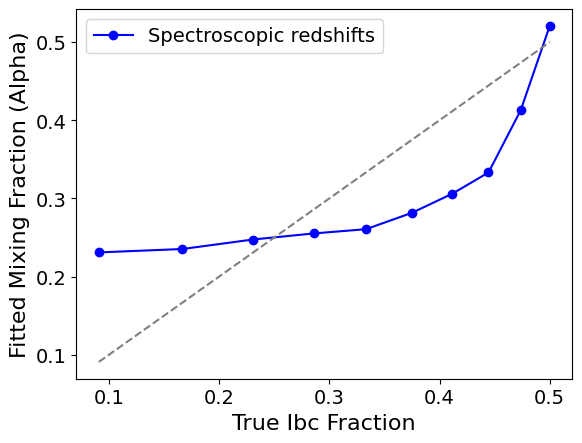

In [953]:
ratios = [(25 * (i + 1))/ (25 * (i + 1) + 250) for i in range(10)]

def mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios):
    final_alphas = []
    accuracies = np.zeros((3, len(ratios)))
    for i in range(10):
        # print(25*(i + 1))
        # split_population = np.concatenate((true_ia_sne, true_ibc_sne[1:25*(i + 1)]))
        split_population = np.concatenate((true_ia_sne[1:len(true_ia_sne)-250*i], true_ibc_sne))

        # print(f"Population split: {(25 * (i + 1))/ (25 * (i + 1) + 250)}")
        # final_alpha, final_ll = fit_gmm(sn_sample = split_population, initial_alpha = (25 * (i + 1))/ (25 * (i + 1) + 250))
        final_alpha, final_ll, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = split_population, initial_alpha = 0.1)
        # print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
        final_alphas.append(final_alpha)
        accuracies[:, i] = classify_sample(split_population, final_gammas_a, final_gammas_b)
    return final_alphas, accuracies

final_alphas_spec, accuracies_spec = mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios)
# final_alphas_phot, accuracies_phot = mixing_fraction_analysis(true_ia_phot_sne, true_ibc_phot_sne, ratios)

plt.plot(ratios, 1 - np.array(final_alphas_spec), marker='o', color='blue', label='Spectroscopic redshifts')
# plt.plot(ratios, 1 - np.array(final_alphas_phot), marker='o', color='red', label='Photometric redshifts')
plt.plot(ratios, ratios, linestyle='--', color='gray')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Fitted Mixing Fraction (Alpha)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

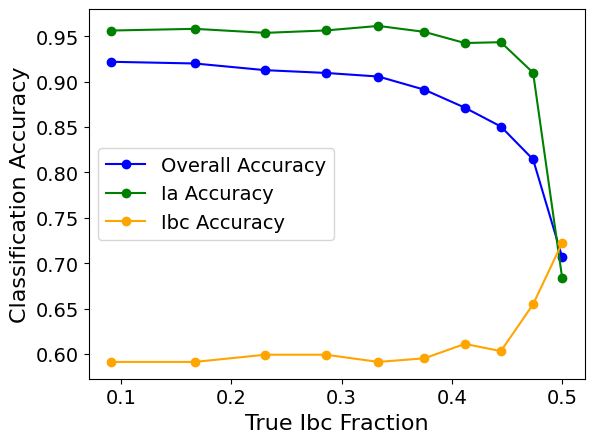

In [954]:
plt.plot(ratios, accuracies_spec[0,:], marker='o', color='blue', label='Overall Accuracy')
plt.plot(ratios, accuracies_spec[1,:], marker='o', color='green', label='Ia Accuracy')
plt.plot(ratios, accuracies_spec[2,:], marker='o', color='orange', label='Ibc Accuracy')

# plt.plot(ratios, accuracies_phot[0,:], marker='o', color='red', label='Photometric redshifts')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()